  * This notebook was made to look at a big picture of surface currents in the plume area with CODAR data, aiming to get some insights of the currents besides line or point comparison.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
import scipy.io as sio
import os
import matplotlib.colors as mcolors
#import seaborn as sns !! This is so confusing for colored scatter plot
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
from __future__ import division
from matplotlib import animation

In [2]:
ferry_stations = {'Tsawwassen': {'lat': 49.0084,'lon': -123.1281},
                  'Duke': {'lat': 49.1632,'lon': -123.8909}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
grid10 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea10.nc')

In [4]:
## load data
codar = sio.loadmat('/ocean/jieliu/research/meopar/salinity_comparison/SoG_radar_totals.mat')
t = codar['mtime']
lat = codar['glat']
lon = codar['glon']
u = codar['u']
v = codar['v']

In [5]:
## initialize the start_time and determine run_time
start_time = datetime.datetime(2014, 10, 8,0)
run_time = datetime.datetime(2014, 10, 8, 0)

In [6]:
from datetime import timedelta
def python_time(run_time):
    run_upper = run_time.replace(minute = 30)
    if run_time.hour != 0:
        run_lower = run_time.replace(hour = run_time.hour-1, minute = 30)
    else:
        run_lower = run_time.replace(day = run_time.day -1,hour =23, minute=30)
    for i,tt  in enumerate(np.arange(0,len(t))):
        matlab_datenum = np.float(t[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        if (python_datetime > run_lower)&(python_datetime < run_upper):
            return python_datetime, i

In [7]:
def plot_codar(run_time):
    axs[0].clear(); axs[1].clear()
    ##plot codar quiver
    viz_tools.plot_coastline(axs[0], grid6, coords = 'map')
    viz_tools.plot_coastline(axs[0], grid6, coords = 'map', isobath = 5,color = 'OrangeRed')
    axs[0].plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    p, ind = python_time(run_time)
    #quiver = axs[0].quiver(lon, lat,u[:,:,ind], v[:,:,ind],pivot='mid',width=0.005, color='black')
    ## to average adjent hours, say average of 16:00 and 17:00 as 16:30
    quiver = axs[0].quiver(lon, lat,np.nanmean(np.array([u[:,:,ind],u[:,:,ind+1]]), axis = 0),\
                    np.nanmean(np.array([v[:,:,ind],v[:,:,ind+1]]),axis =0),\
                           pivot='mid', width=0.005, color='black')
    axs[0].quiverkey(quiver,-123.1,49.35, 1, '1 m/s',
                    coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)
    stations=['Tsawwassen','Duke']
    for stn in stations:
        axs[0].plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='SpringGreen',\
                 markersize=10, markeredgewidth=2)
    axs[0].annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon']-0.07 ,\
    ferry_stations['Tsawwassen']['lat'] + 0.02), fontsize=15, color='black', bbox=bbox_args )
    axs[0].annotate ('Duke Point',(ferry_stations['Duke']['lon'] -0.11 ,\
    ferry_stations['Duke']['lat']-0.05 ),fontsize=15, color='black', bbox=bbox_args )
    ## add ferry salinity if it has
    sc = seek_ferry_time(axs[0], run_time,value_flag = False)
    
    lonax = [-124.0,-123]
    latax= [48.9,49.4]   
    axs[0].set_xlim(lonax)
    axs[0].set_ylim(latax)
    plt.setp(axs[0].get_xticklabels(), fontsize=10)
    plt.setp(axs[0].get_yticklabels(), fontsize=10)
    axs[0].set_xlabel('Longitude')
    axs[0].set_ylabel('Latitude')
    axs[0].set_title('codar surface currents on '+run_time.replace(minute = 30).strftime\
                     ('%d-%b-%Y %H:%M'), fontsize = 15)
    ## plot ssh at PA
    directory = '/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/'
    path = os.path.join(directory, 'SalishSea_1h_20141008_20141010_grid_T.nc')
    grid_T = nc.Dataset(path,'r')
    ssh =grid_T.variables['sossheig']
    timesteps = grid_T.variables['time_counter'][:]
    t_t = nc_tools.timestamp(grid_T, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t)   
    start_time = datetime.datetime(2014,10,8,0,0)
    hrs = (run_time.day-start_time.day)*24+ run_time.hour - start_time.hour  
    axs[1].plot(tt,ssh[:,466,329],'-k')
    axs[1].plot(tt[hrs],ssh[hrs, 466, 329],'o',color='tomato',markersize=9)
    axs[1].set_ylabel('Water level (m)')
    axs[1].set_title('Modelled water level at Point Atkinson on '+ \
                run_time.replace(minute = 30).strftime('%d-%b-%Y %H:%M'),fontsize = 15)
    return quiver

In [8]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st=3
cmin, cmax, dels = -6, 6, 0.6

In [9]:
def plot_ModelCurrent(run_time):
    """This function was made to create difference of modelled surface 
       currents at the corresponding time with bathymetry 6 & 10"""
    base = '/data/jieliu/MEOPAR/river-treatment/'
    runs = [ 'oct8_10jetty1e0605','oct8_101e061e05']
    u_m = {};v_m = {};S_m = {};U_m ={};V_m={};
    baths = [grid10, grid6]
    for run, ax,grid in zip(runs,axs[:2],baths):
        path = os.path.join(base, '{}/SalishSea_1h_20141008_20141010_grid_U.nc'.format(run))
        grid_U = nc.Dataset(path,'r')
        t = (run_time.day-8)*23+run_time.hour
        u_m[run] =grid_U.variables['vozocrtx'][t, 0,jst-1:jen,ist-1:ien]
        path = os.path.join(base, '{}/SalishSea_1h_20141008_20141010_grid_V.nc'.format(run))
        grid_V = nc.Dataset(path,'r')
        v_m[run] =grid_V.variables['vomecrty'][t, 0,jst-1:jen,ist-1:ien]
        path = os.path.join(base, '{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(run))
        grid_T = nc.Dataset(path,'r')
        S_m[run] = grid_T.variables['vosaline'][t, 0, jst:jen,ist:ien]
        lon = grid.variables['nav_lon'][jst:jen,ist:ien]
        lat = grid.variables['nav_lat'][jst:jen,ist:ien]
        ##unstagger u v
        U_m[run],V_m[run] = viz_tools.unstagger(u_m[run],v_m[run])
        #rotate
        theta = np.pi*29/180
        U_m[run] = U_m[run]*np.cos(theta) - V_m[run]*np.sin(theta)
        V_m[run] = U_m[run]*np.sin(theta) +V_m[run]*np.cos(theta)
        ##mask
        U_m[run]=np.ma.masked_values(U_m[run],0)
        V_m[run]=np.ma.masked_values(V_m[run],0)
    
        cm = plt.cm.get_cmap('spectral',12)
        mesh=ax.pcolormesh(lon,lat,S_m[run],vmin =10,\
                        vmax = 30,cmap=cm)
        
        quiver = ax.quiver(lon[::st,::st], lat[::st,::st],U_m[run][ ::st, ::st], V_m[run][::st,::st],\
                           pivot='mid',scale=10,width=0.005, color='black' )
        ax.quiverkey(quiver,-123.1,49.35, 1, '1 m/s',
                        coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '20'})
        viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
        ## add minimum salinity plot if available
        point_plot = plot_route_min(ax, run_time)
               
        ax.set_xlim([-124.,-123])
        ax.set_ylim([48.9,49.4])
        
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Practical Salinity', fontsize = 20)

        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 15) 
        ax.set_title(run_time.replace(minute = 30).strftime('%d-%b-%Y %H:%M')+\
        ' Surface currents and salinity of {}'.format(run), fontsize = 20)
    ## plot the difference    
    ax = axs[2]
    sal_diff = S_m[runs[0]] - S_m[runs[1]]
    U_diff = U_m[runs[0]] - U_m[runs[1]]
    V_diff = V_m[runs[0]] - V_m[runs[1]]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=10,width=0.005, color='black' )
    ax.quiverkey(quiver,-123.1,49.35, 1, '1 m/s',
                        coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '20'})
    viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label(' Salinity difference',fontsize = 20)
    ax.set_title('difference between bathymetry10 and 6 on\
    '+run_time.replace(minute = 30).strftime('%d-%b-%Y %H:%M'),fontsize = 20)
    ax.set_xlim([-124.,-123])
    ax.set_ylim([48.9,49.4])
    for ax in axs:
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20) 
        ax.set_xticks([-124,-123.8,-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-124,-123.8,-123.6, -123.4, -123.2,-123])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
    return quiver

In [10]:
def seek_ferry_time(ax,run_time, value_flag=True):
    """if value_flag =true, it returns only minimum ferry
       salinity value and location, else, it returns plot,
       if not within ferry running time, return None"""
    
    directory = '/ocean/jieliu/research/meopar/autodataupdate/ferrydata/';
    base = 'SBE19'
    if run_time.hour ==0 or run_time.hour ==3 or run_time.hour ==5:
        path = os.path.join(directory,'{}'.format(base)+\
                run_time.replace(day = run_time.day -1).strftime('%Y%m%d')+'.mat')
    elif run_time.hour == 12 or run_time.hour ==14 or run_time.hour ==16 or \
        run_time.hour ==19 or run_time.hour ==21:
        path = os.path.join(directory,'{}'.format(base)+\
                run_time.replace(day = run_time.day ).strftime('%Y%m%d')+'.mat')
    else:
        path = []
    if path!= []:
        saline = sio.loadmat(path)
        dataa = saline['ferryData']['data'][0,0]
        time=dataa['matlabtime'][0,0]
        lonn=dataa['Longitude'][0,0]
        latt=dataa['Latitude'][0,0]
        salinity=dataa['Practical_Salinity'][0,0]
        
        a=len(time)
        lon1=np.zeros([a,1])
        lat1=np.zeros([a,1])
        salinity1=np.zeros([a,1])
        if run_time.hour ==3 or run_time.hour ==5 or run_time.hour ==12 or run_time.hour ==19:
            run_lower = run_time.replace( minute = 15)#!!more convenient than day,miniute..
            run_upper = run_time.replace(hour= run_time.hour + 2, minute=45)
        else:
            run_lower = run_time.replace( minute = 45)
            if run_time.hour ==16 or run_time.hour ==0:
                run_upper = run_time.replace(hour= run_time.hour + 3, minute=15)
            else:
                 run_upper = run_time.replace(hour= run_time.hour + 2, minute=45)                            
        for i in np.arange(0,a):
            matlab_datenum = np.float(time[i])
            python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
            + timedelta(days=matlab_datenum%1) - timedelta(days = 366)

            if (python_datetime >= run_lower) &(python_datetime <= run_upper):
                lon1[i]=lonn[i]
                lat1[i]=latt[i]
                salinity1[i]=salinity[i]
        mask=lon1[:,0]!=0
        lon1_2_4=lon1[mask]
        lat1_2_4=lat1[mask]
        salinity1_2_4=salinity1[mask]
        
        if value_flag:## just return salinity and location
            return lon1_2_4, lat1_2_4, salinity1_2_4
        else:
            ##plot    
            cm = plt.cm.get_cmap('spectral',12)
            sc = ax.scatter(lon1_2_4[::5], lat1_2_4[::5], c = salinity1_2_4[::5], vmin =10,\
                        vmax = 30, s =30, cmap = cm)
            cbar = plt.colorbar(sc, ax=ax)
            cbar.set_label('Practical Salinity', fontsize = 9)
            return sc
    else: 
        return None

In [11]:
def plot_route_min(ax, run_time):
    """This function was made to plot ferry route on modelled map
        as well as location of minimum salinity value"""
    ## plot route
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)
    stations=['Tsawwassen','Duke']
    for stn in stations:
        ax.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='SpringGreen',\
                 markersize=15, markeredgewidth=2)
    ax.annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon']-0.07 ,\
    ferry_stations['Tsawwassen']['lat'] + 0.02), fontsize=20, color='black', bbox=bbox_args )
    ax.annotate ('Duke Point',(ferry_stations['Duke']['lon'] -0.11 ,\
    ferry_stations['Duke']['lat']-0.05 ),fontsize=20, color='black', bbox=bbox_args )
    ## plot location of minimum salinity value
    
    if run_time.hour ==0 or run_time.hour ==3 or run_time.hour ==5 or\
    run_time.hour == 12 or run_time.hour ==14 or run_time.hour ==16 or \
    run_time.hour ==19 or run_time.hour ==21:
        lon1_2_4, lat1_2_4,salinity1_2_4 = seek_ferry_time(ax, run_time, value_flag = True)
        ## find minimum salinity value and location(for all points,
        ##rather than every five points)
        min_sal = np.nanmin(salinity1_2_4)
        ind = np.nanargmin(salinity1_2_4)        
        min_loca = lon1_2_4[ind]
        min_lat = lat1_2_4[ind]
        route_plot = ax.plot(lon1_2_4, lat1_2_4, 'k',linewidth = 5)
        point_plot = ax.plot(min_loca,min_lat, '*b', markersize = 20)
        print ('minimum ferry salinity value is', min_sal)
        print ('longitude of minimum salinity value is', min_loca)
        print ('latitude of minimum salinity value is', min_lat)
        return route_plot,point_plot
    else:
        return None

# plot

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


minimum ferry salinity value is 13.2768
longitude of minimum salinity value is [-123.42503499]
latitude of minimum salinity value is [ 49.06601749]
minimum ferry salinity value is

/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 13.2768
longitude of minimum salinity value is [-123.42503499]
latitude of minimum salinity value is [ 49.06601749]


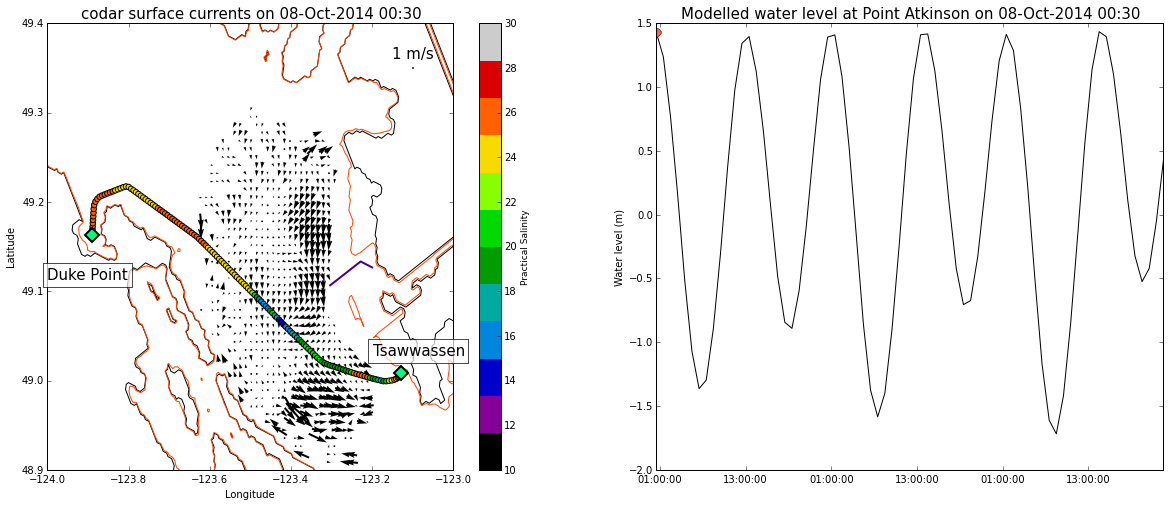

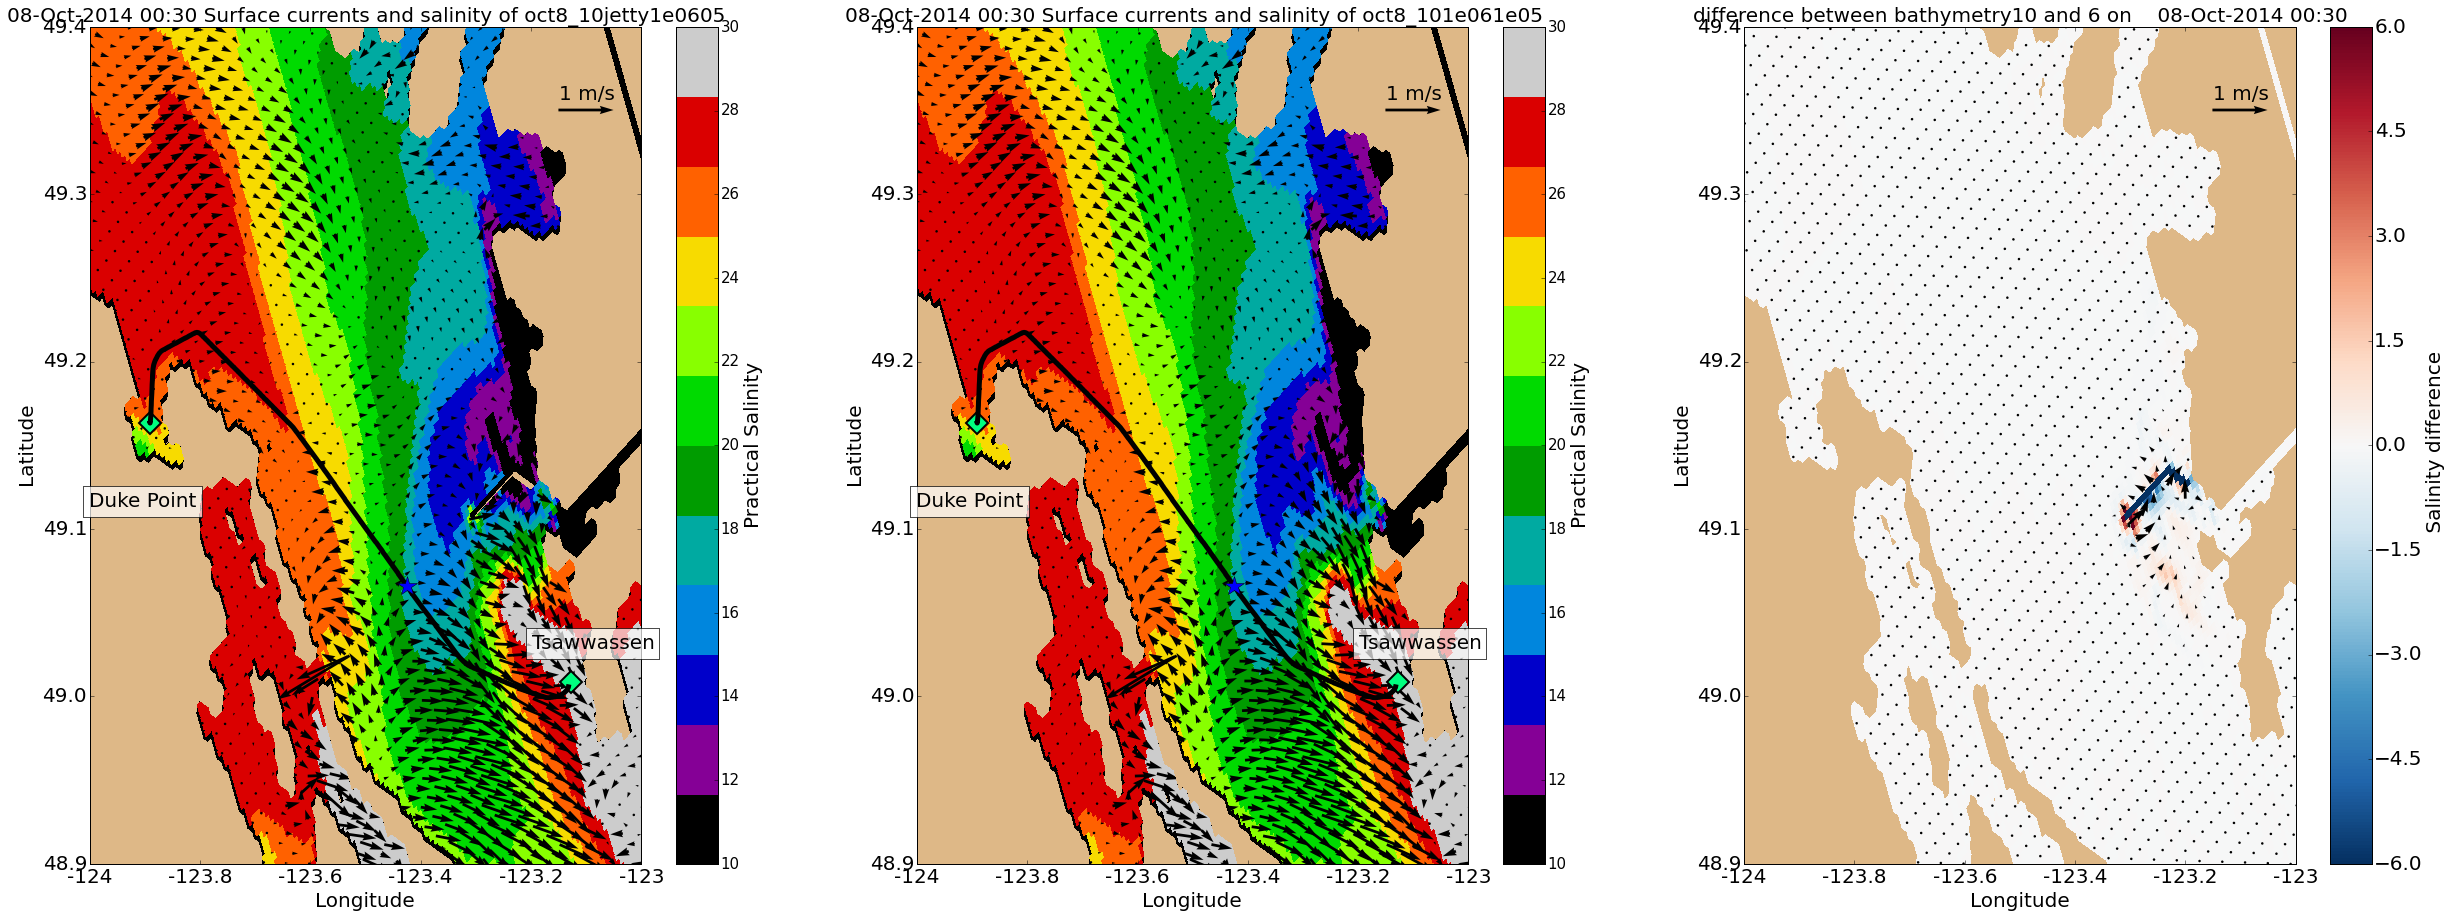

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
quiver = plot_codar(run_time)
fig, axs = plt.subplots(1, 3, figsize=(42, 15))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


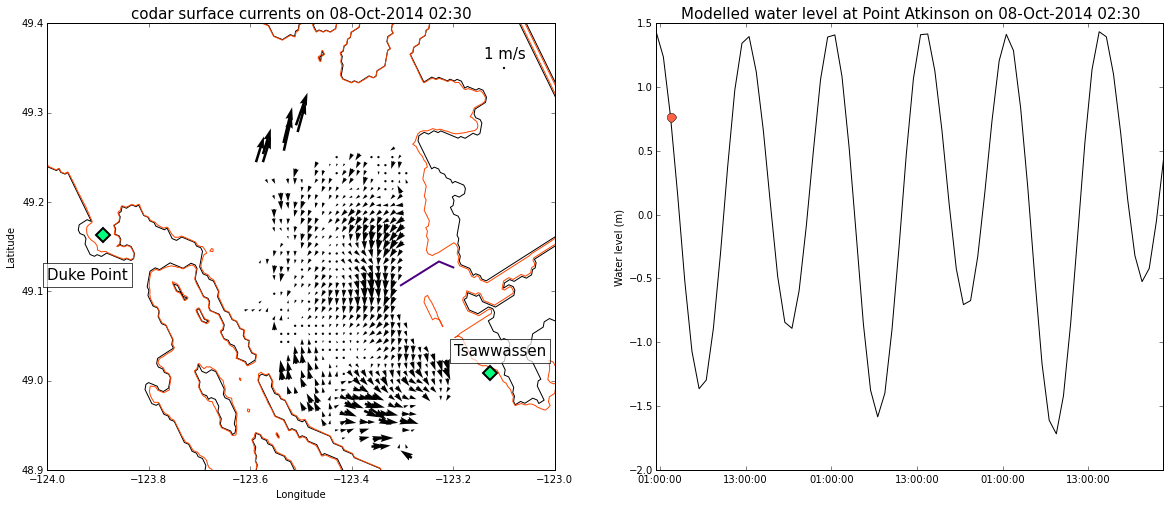

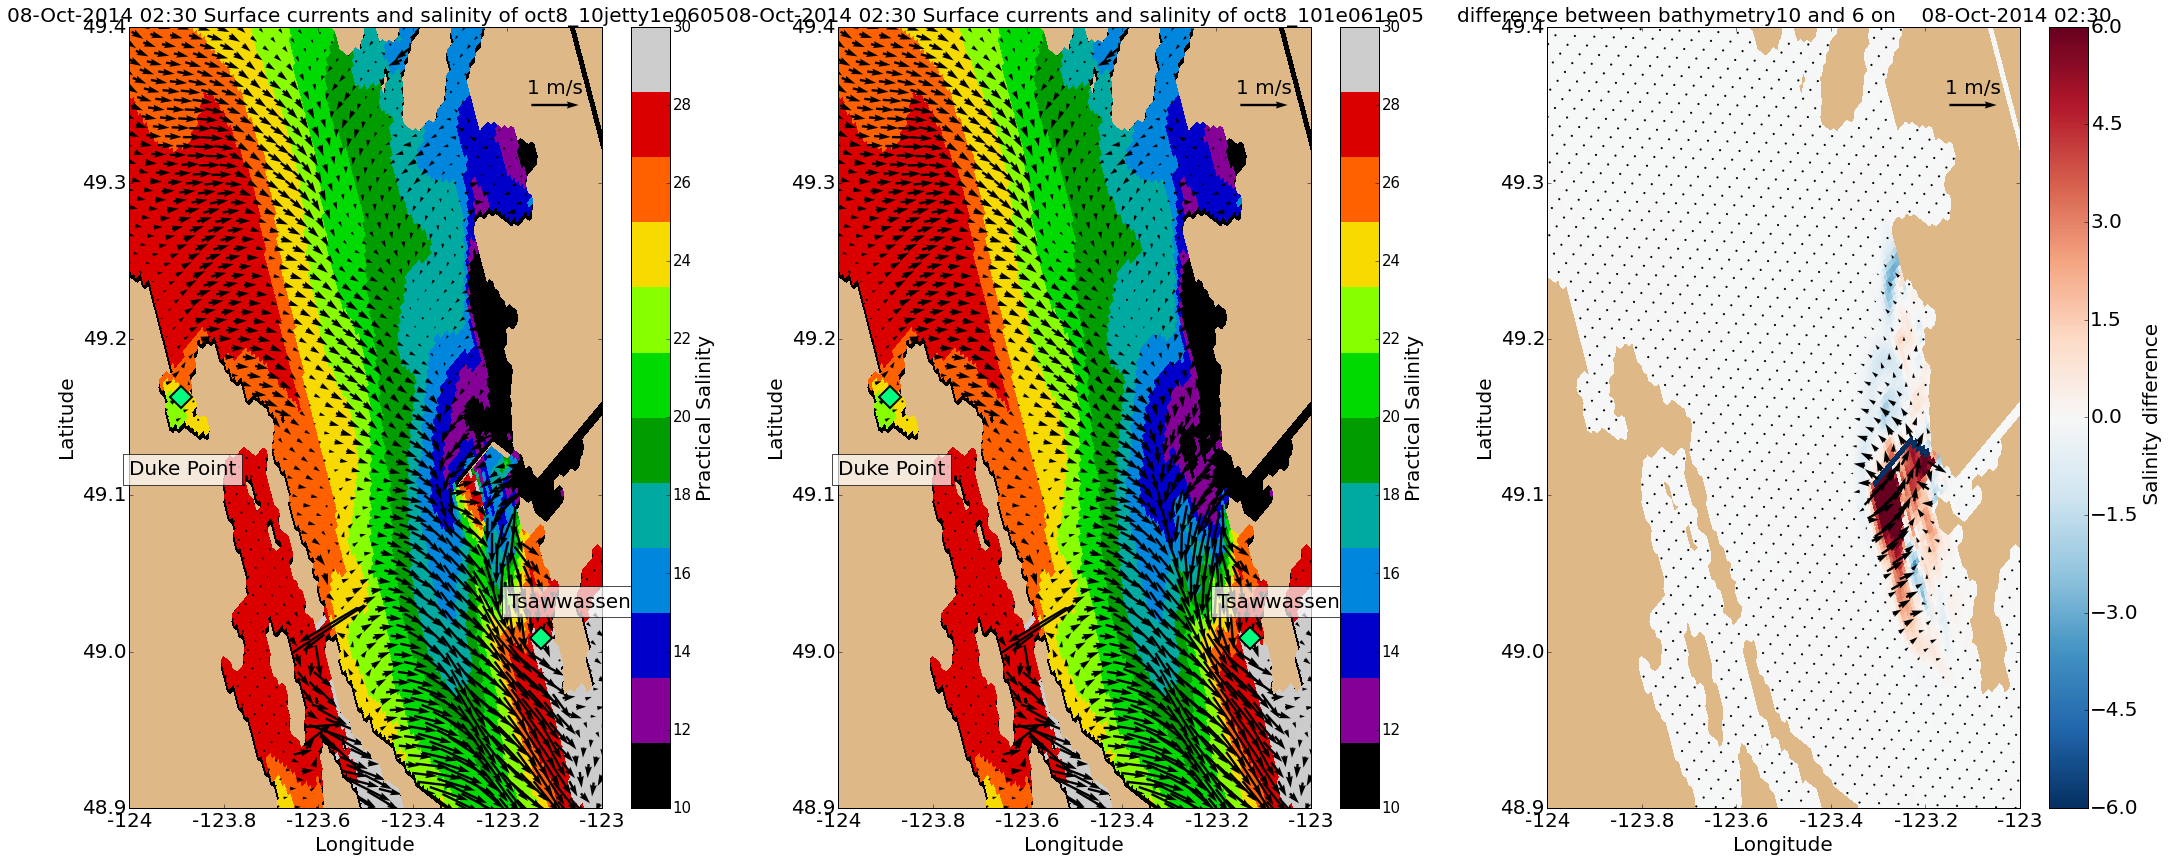

In [13]:
run_time = run_time.replace(hour = 2)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
quiver = plot_codar(run_time)
fig, axs = plt.subplots(1, 3, figsize=(36, 14))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


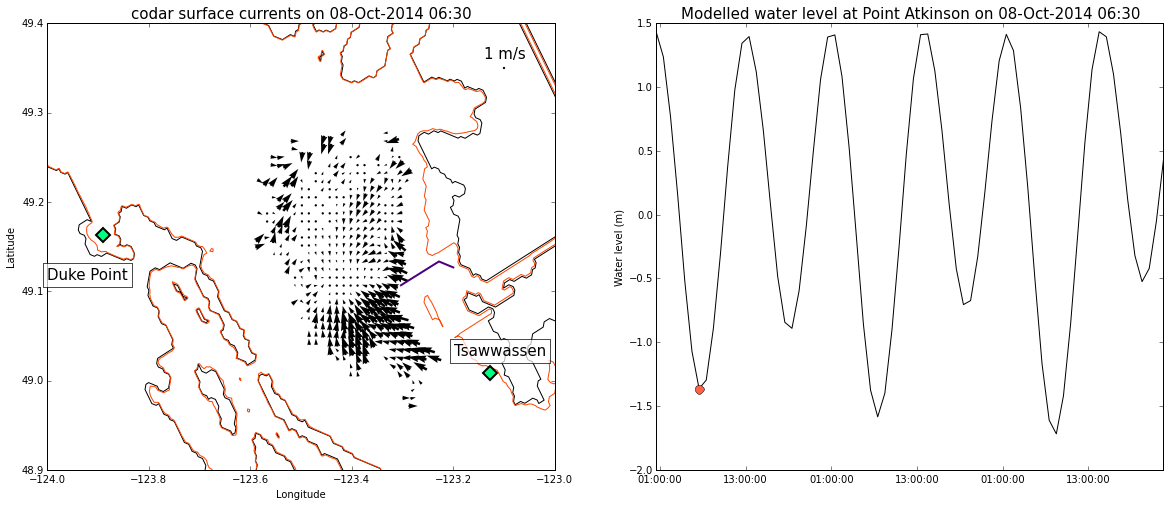

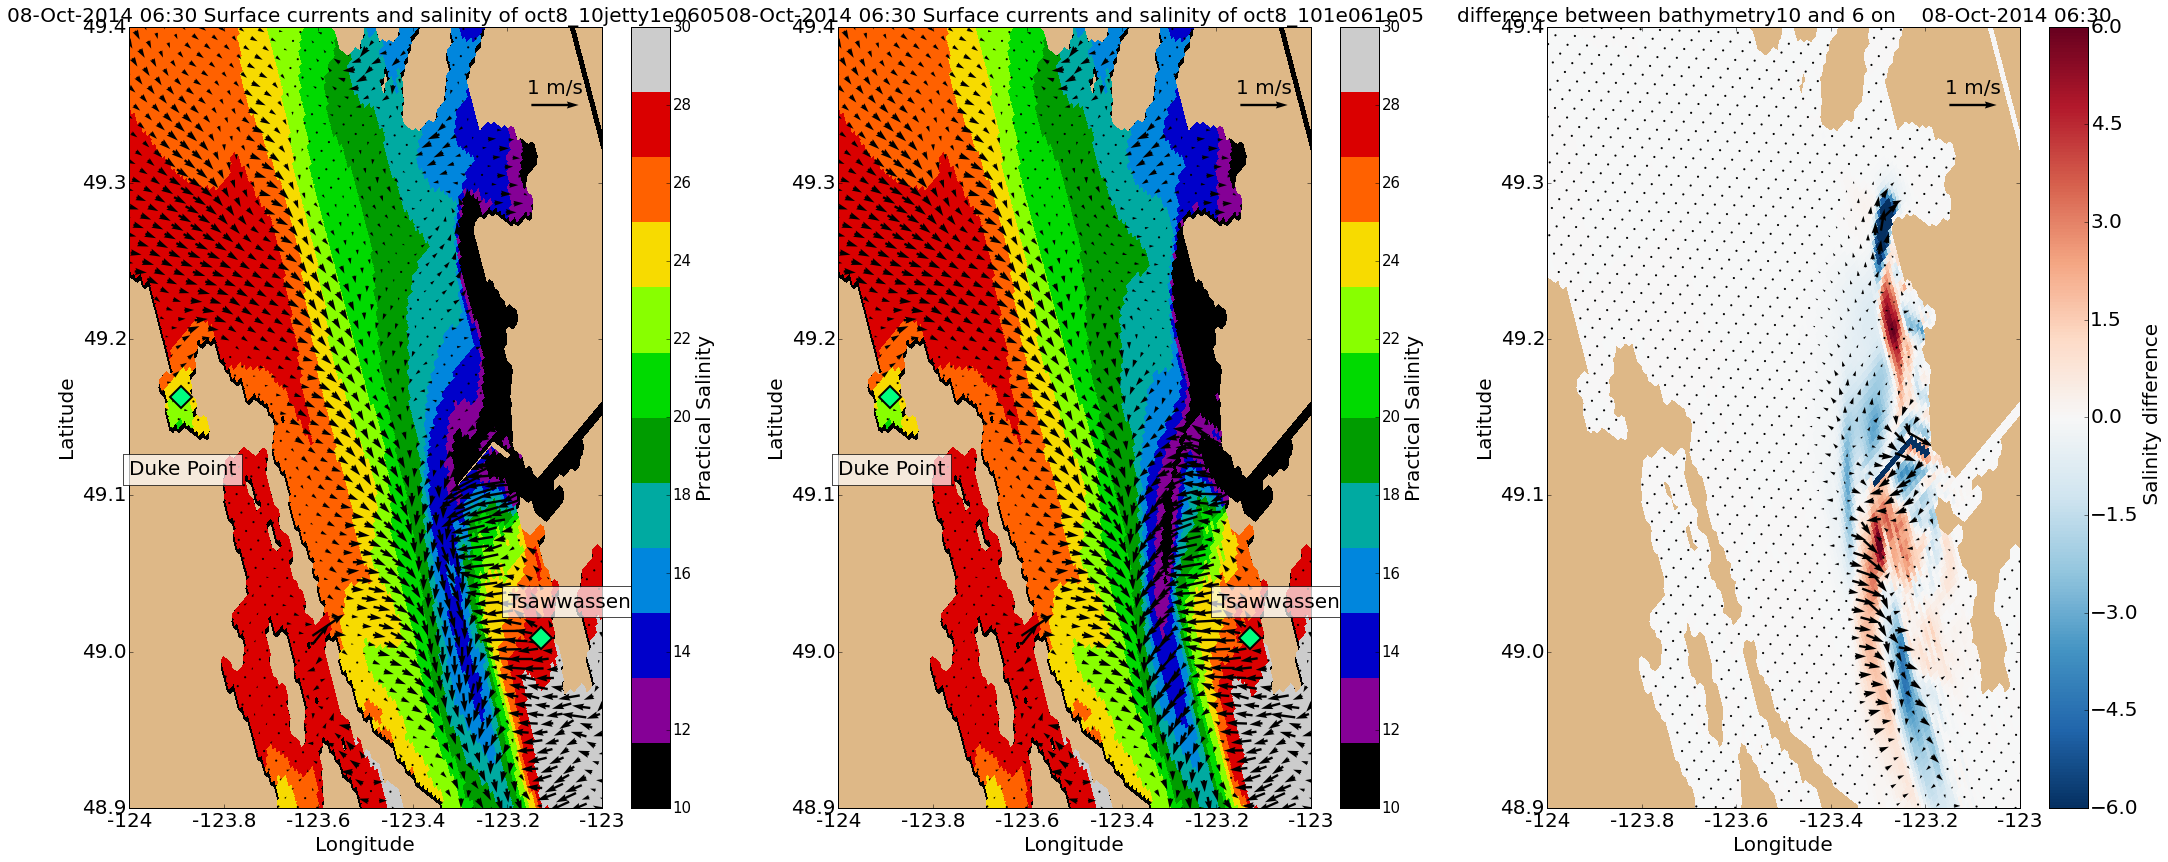

In [14]:
run_time = run_time.replace(hour = 6)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
quiver = plot_codar(run_time)
fig, axs = plt.subplots(1, 3, figsize=(36, 14))
quiver = plot_ModelCurrent(run_time)

# For drifter start time on Oct8

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


minimum ferry salinity value is 13.6288
longitude of minimum salinity value is [-123.32531687]
latitude of minimum salinity value is [ 49.05084036]
minimum ferry salinity value is

/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 13.6288
longitude of minimum salinity value is [-123.32531687]
latitude of minimum salinity value is [ 49.05084036]


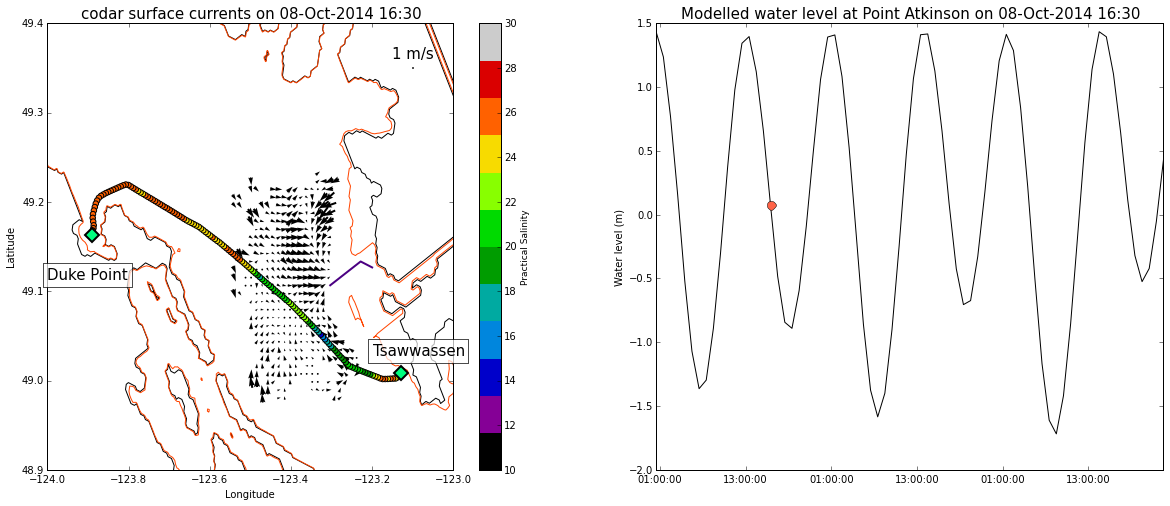

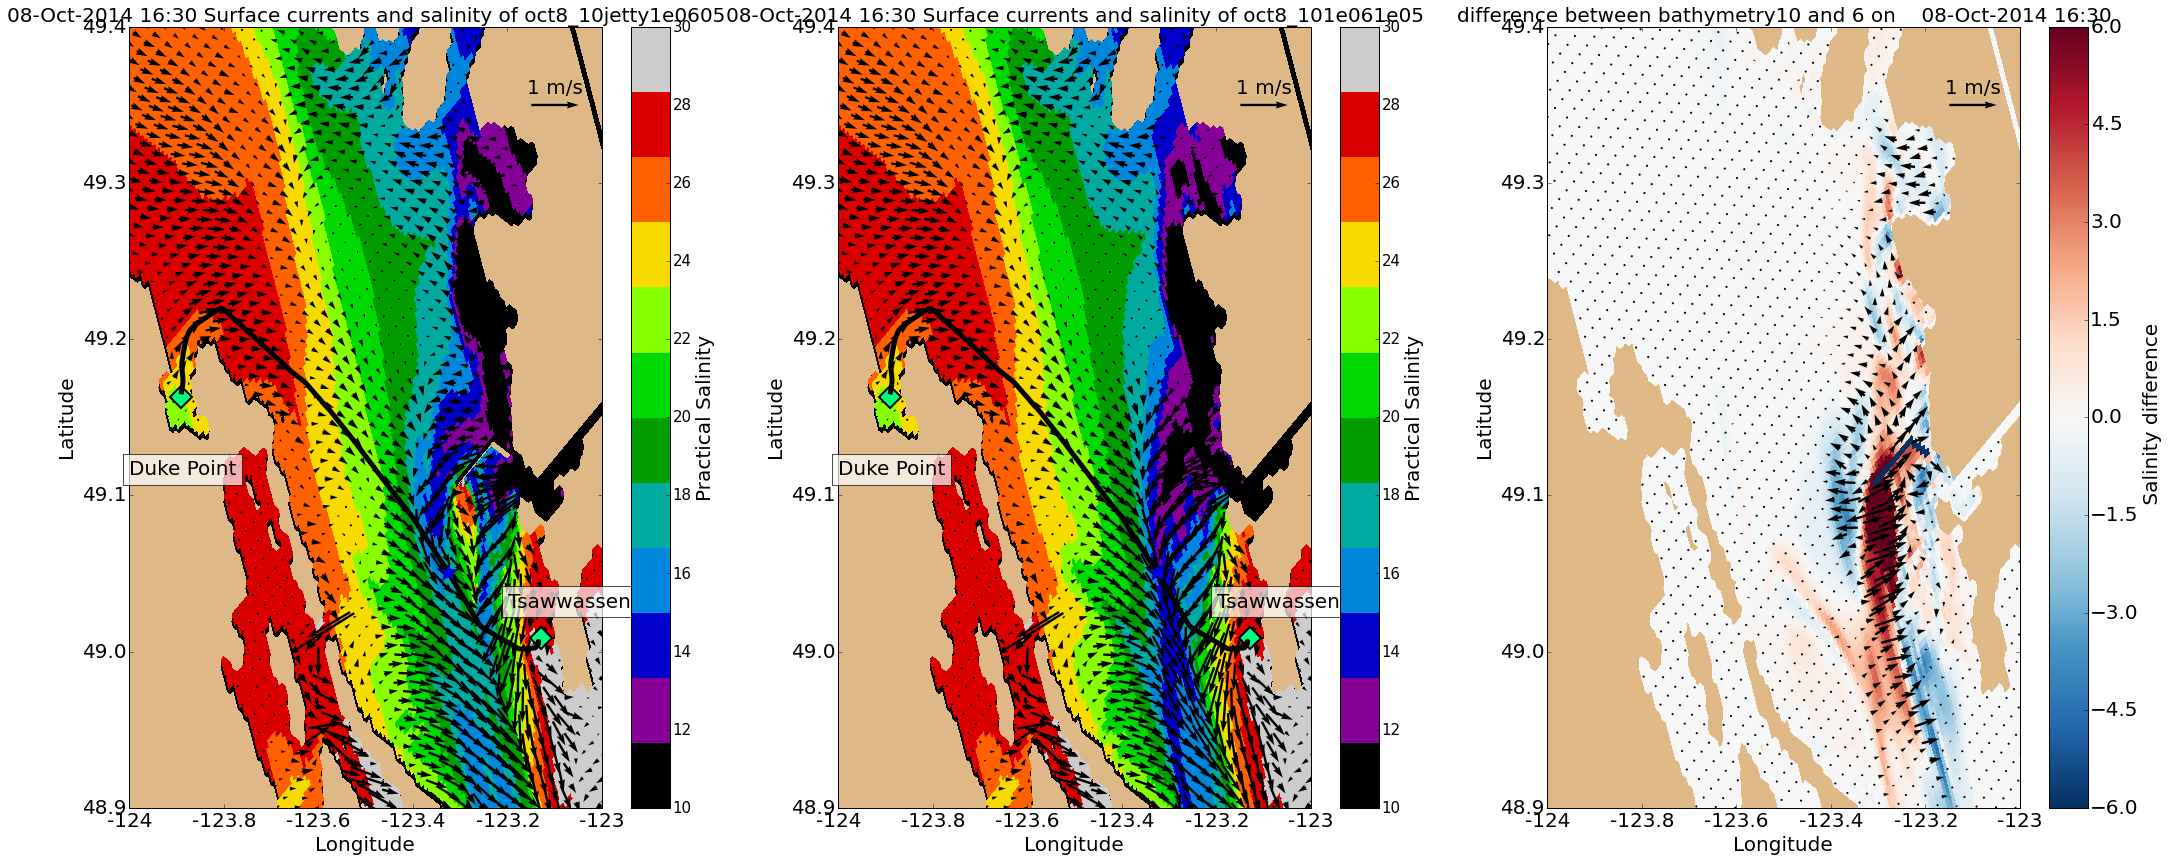

In [15]:
run_time = run_time.replace(hour = 16)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
quiver = plot_codar(run_time)
fig, axs = plt.subplots(1, 3, figsize=(36, 14))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


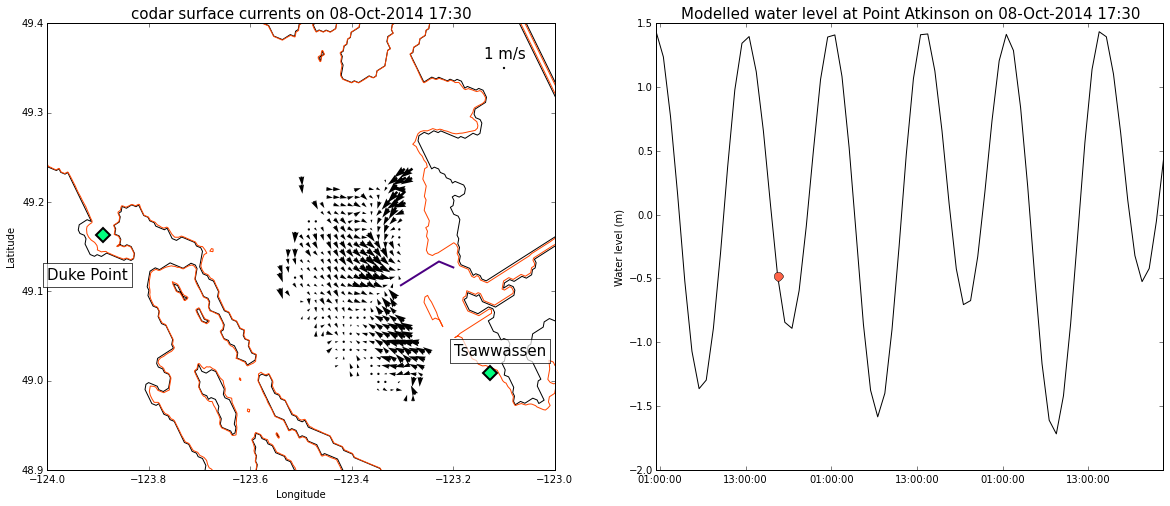

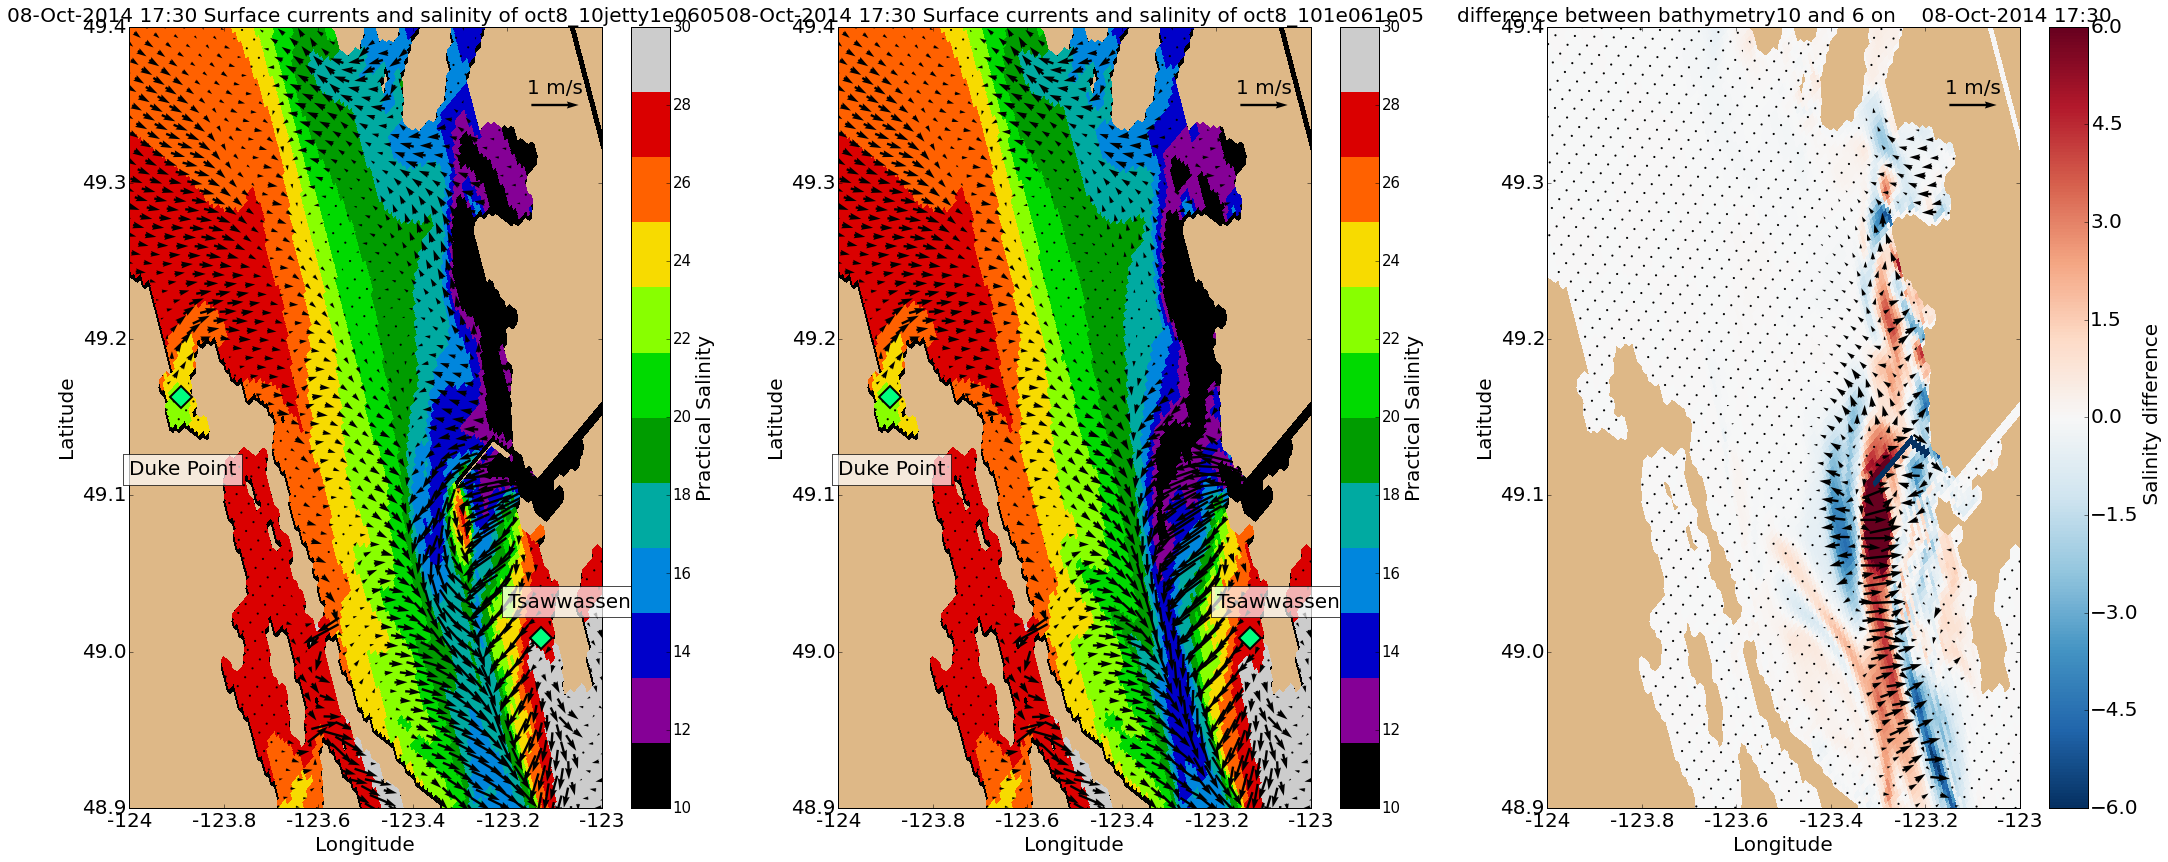

In [16]:
run_time = run_time.replace(hour = 17)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
quiver = plot_codar(run_time)
fig, axs = plt.subplots(1, 3, figsize=(36, 14))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


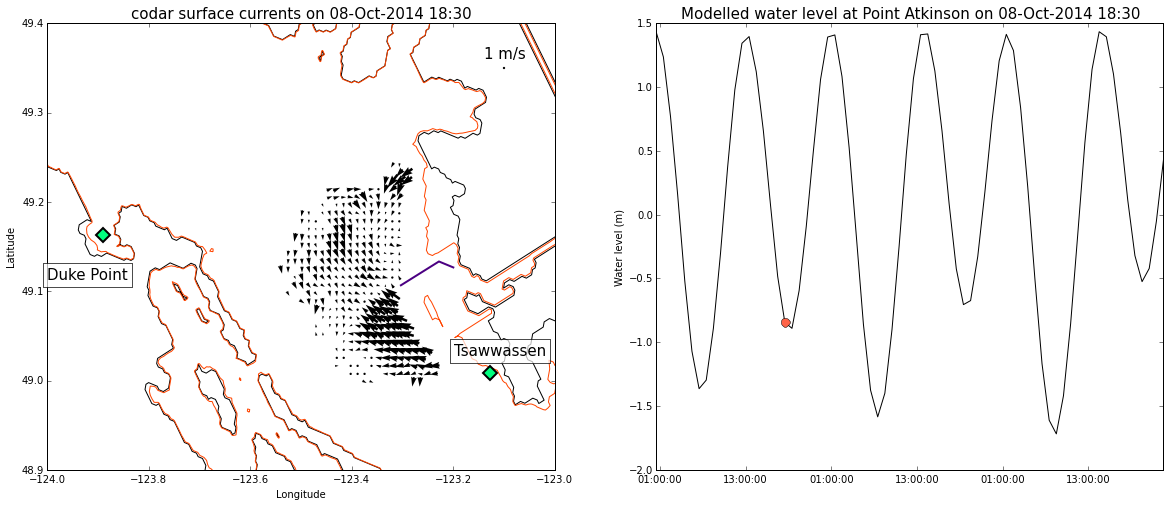

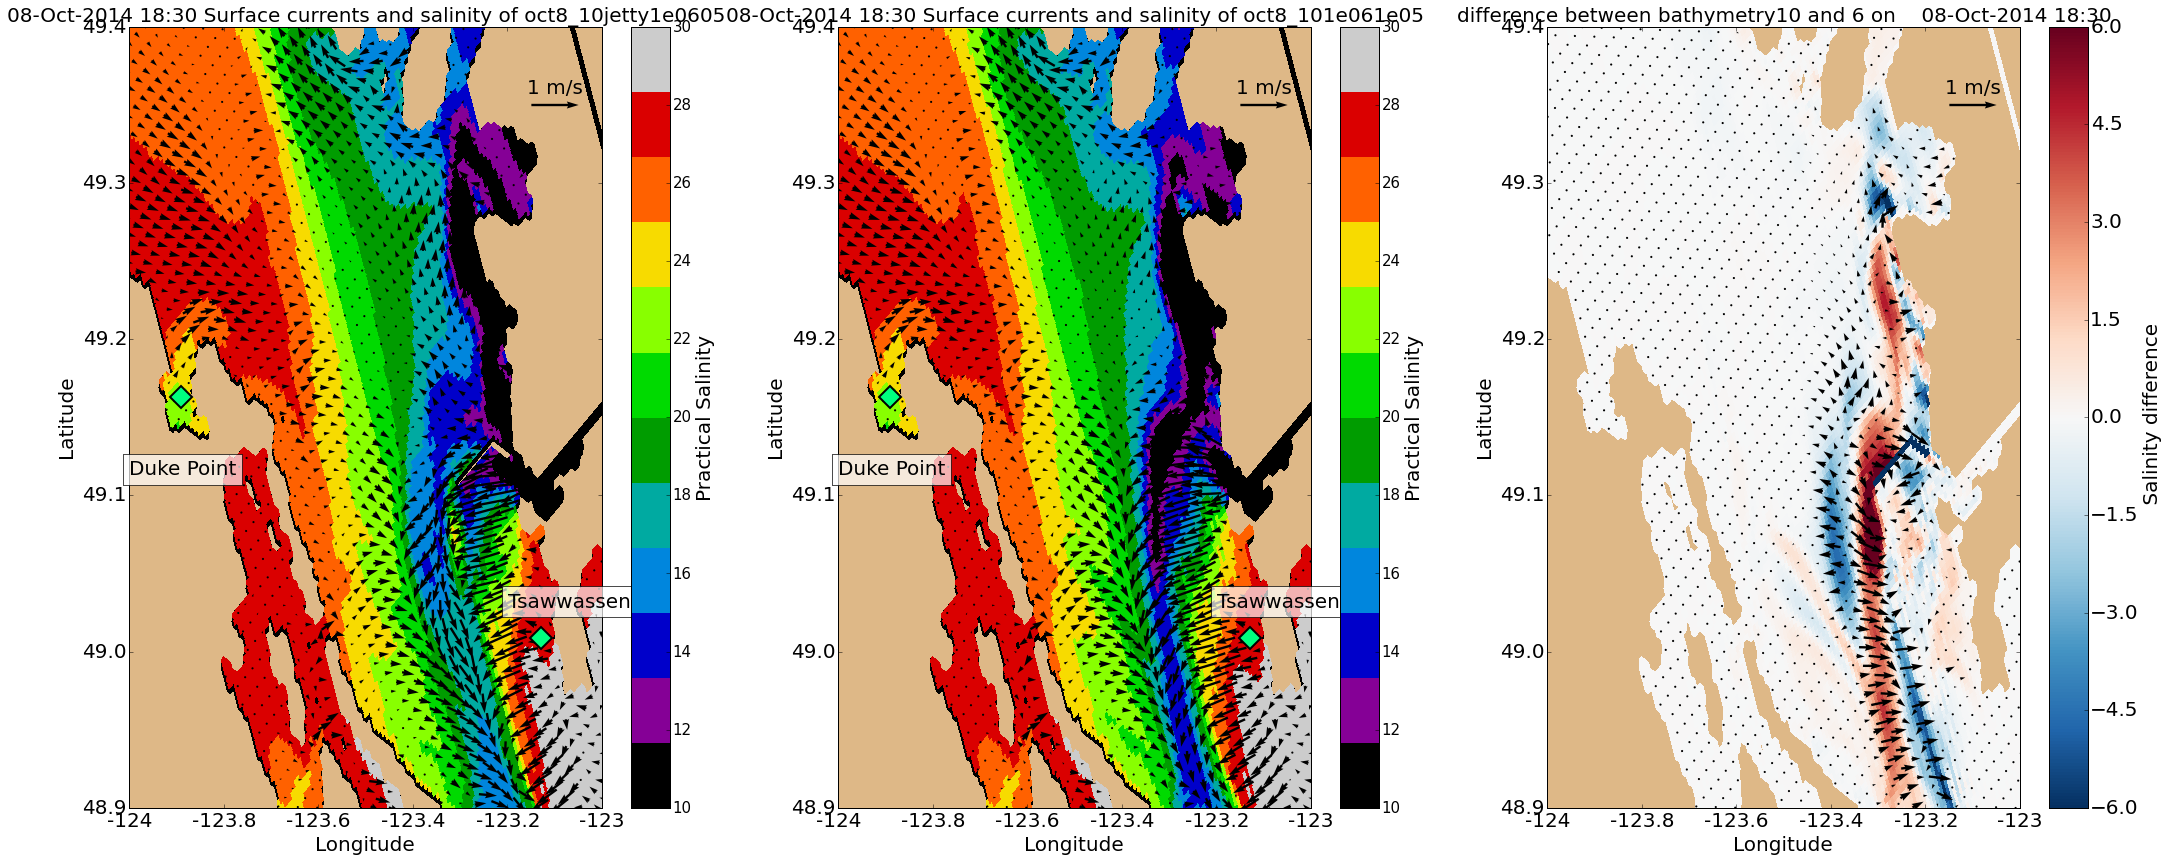

In [17]:
run_time = run_time.replace(hour = 18)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
quiver = plot_codar(run_time)
fig, axs = plt.subplots(1, 3, figsize=(36, 14))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


minimum ferry salinity value is 12.997
longitude of minimum salinity value is [-123.421409]
latitude of minimum salinity value is [ 49.066305]
minimum ferry salinity value is

/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 12.997
longitude of minimum salinity value is [-123.421409]
latitude of minimum salinity value is [ 49.066305]


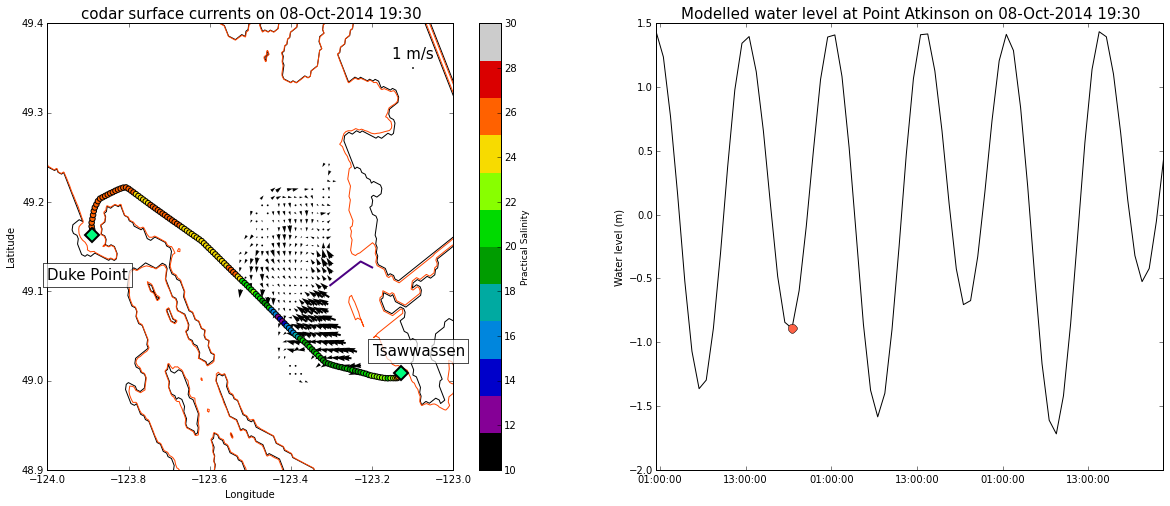

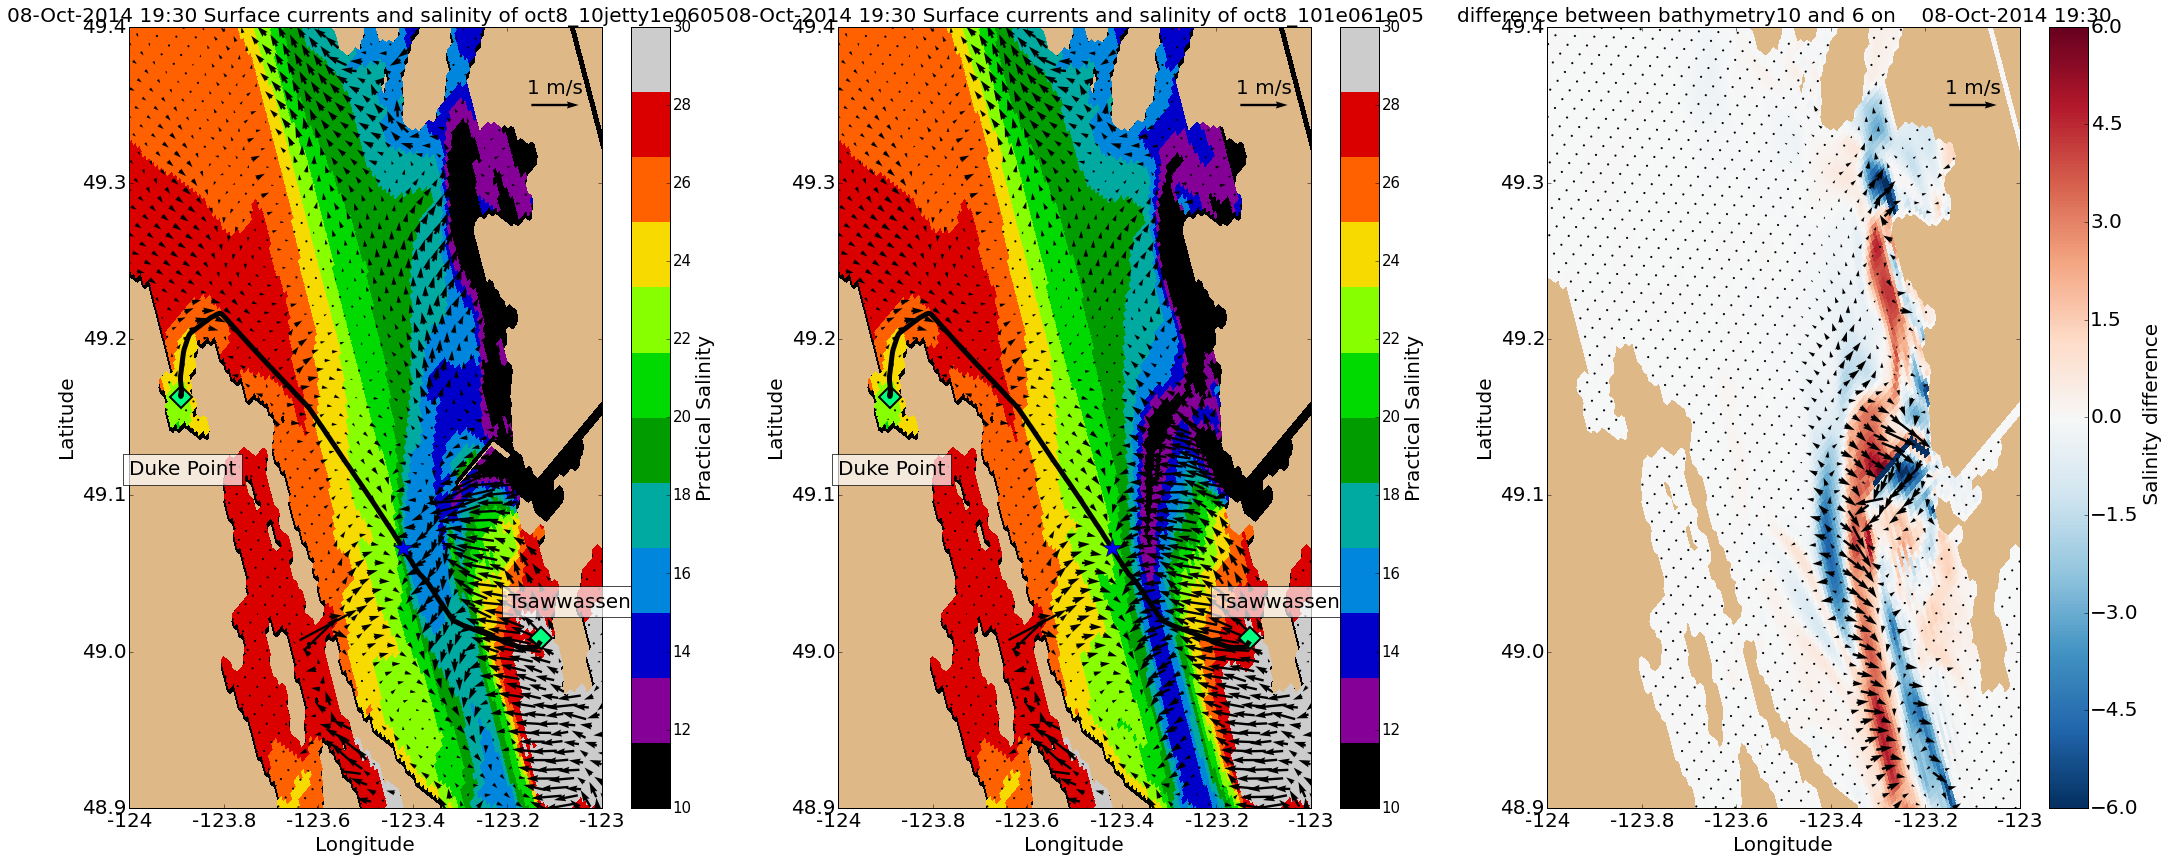

In [18]:
run_time = run_time.replace(hour = 19)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
quiver = plot_codar(run_time)
fig, axs = plt.subplots(1, 3, figsize=(36, 14))
quiver = plot_ModelCurrent(run_time)

* What the codar data gives me the feeling like there is a boundary of plume motion separation at around 49.1 latitude, right at the head of jetty, below which strong cross strait velocity is found, above which it goes in the cyclonic rotation during ebb tide. I think two different mechanisms caused this difference. Wind? Tide?
* During strong ebb tide, which is nearly turning point to flood tide, strong cross strait velocity in the southward of plume show up.

# No data for drifter end time

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


minimum ferry salinity value is 14.8318
longitude of minimum salinity value is [-123.26069992]
latitude of minimum salinity value is [ 49.02798179]
minimum ferry salinity value is

/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


 14.8318
longitude of minimum salinity value is [-123.26069992]
latitude of minimum salinity value is [ 49.02798179]


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


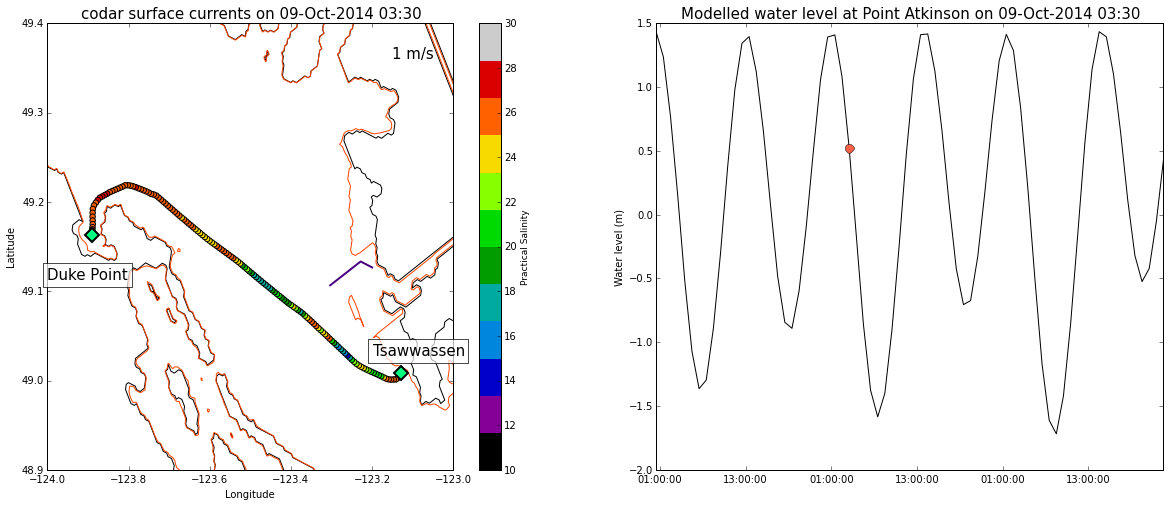

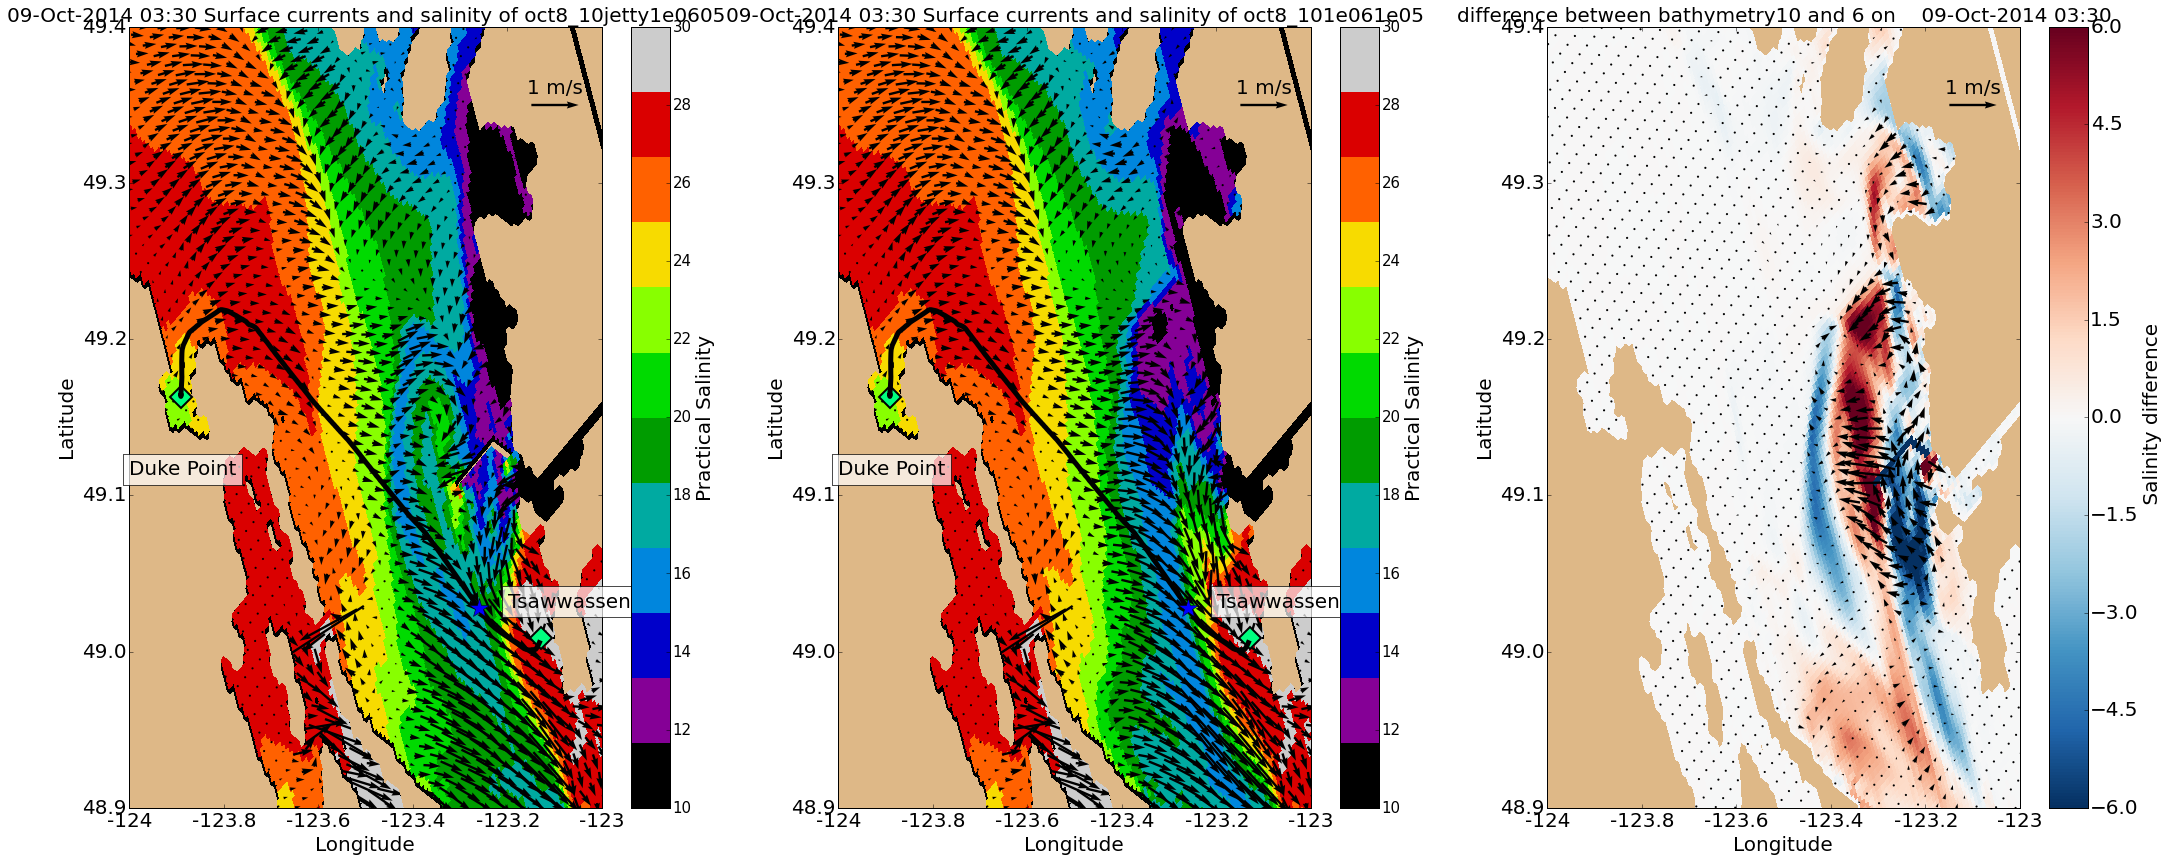

In [19]:
run_time = run_time.replace(hour = 3, day = 9)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
quiver = plot_codar(run_time)
fig, axs = plt.subplots(1, 3, figsize=(36, 14))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


minimum ferry salinity value is 17.1712
longitude of minimum salinity value is [-123.42343871]
latitude of minimum salinity value is [ 49.10554624]
minimum ferry salinity value is

/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 17.1712
longitude of minimum salinity value is [-123.42343871]
latitude of minimum salinity value is [ 49.10554624]


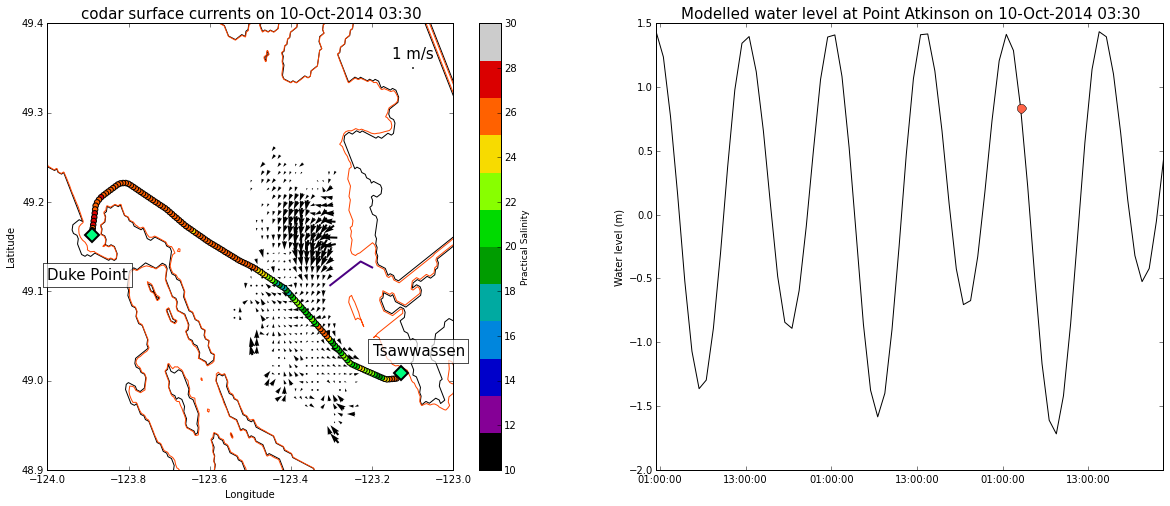

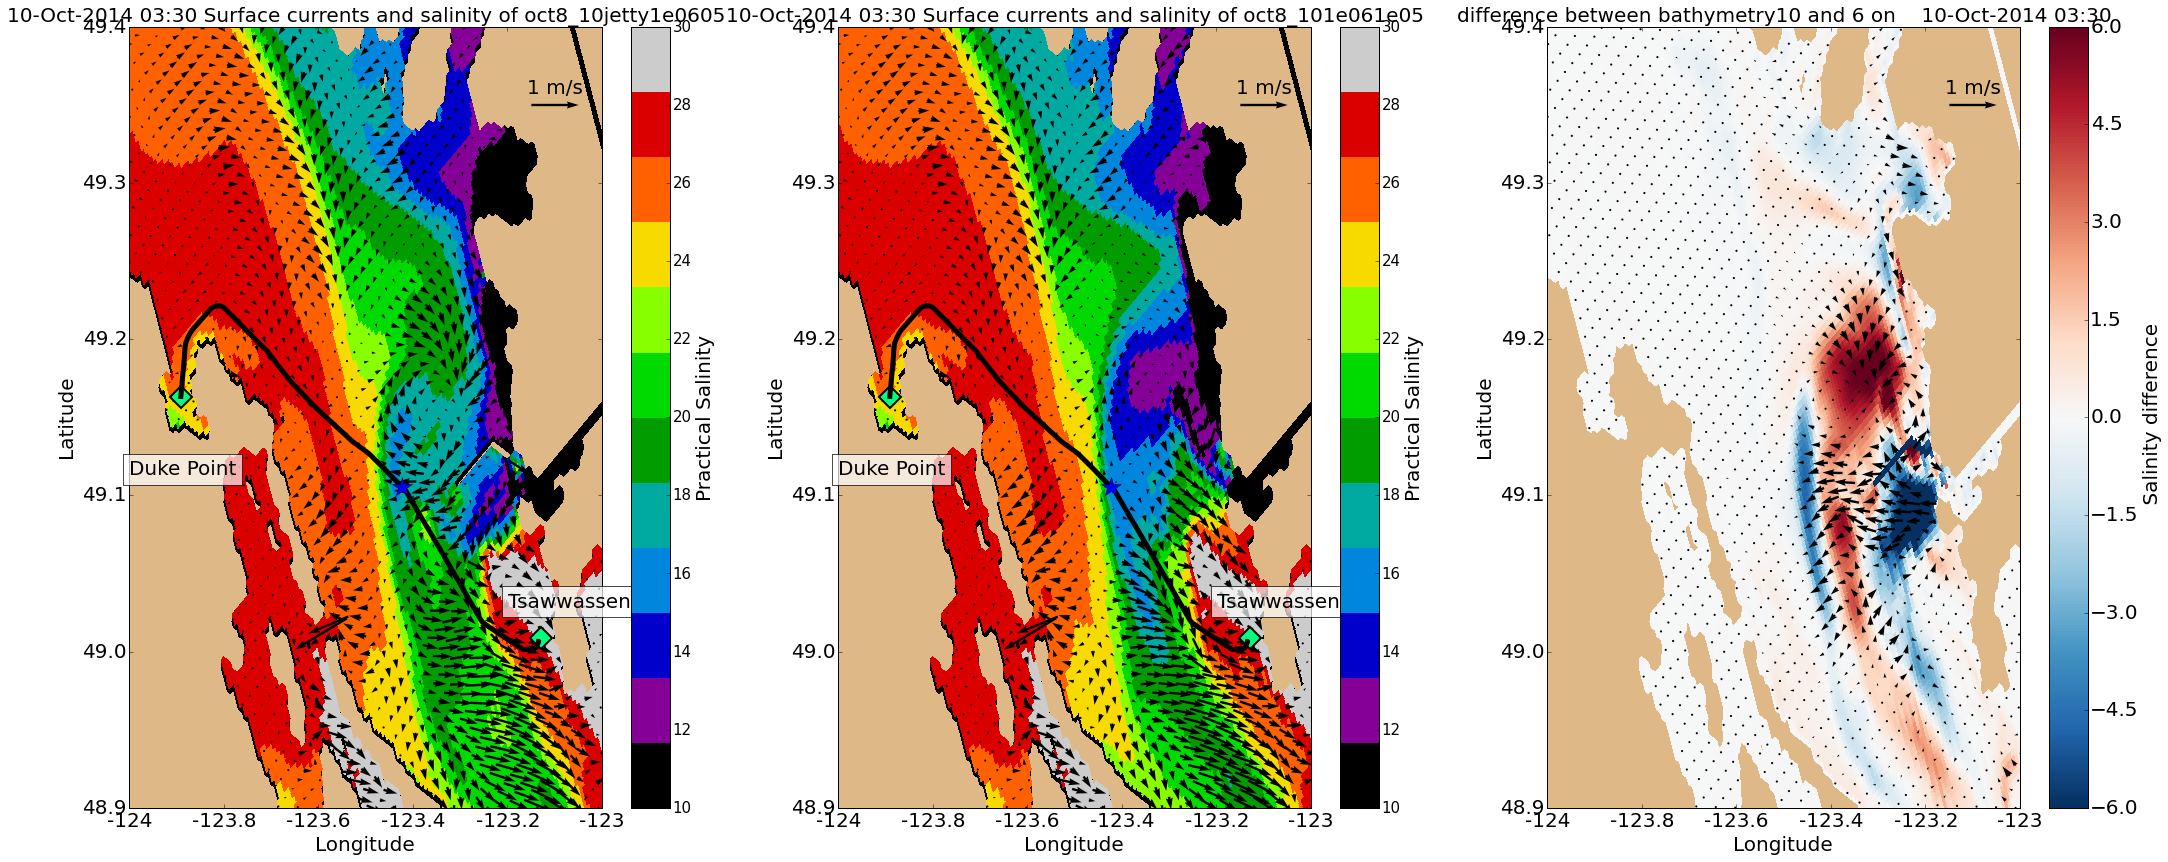

In [20]:
run_time = run_time.replace(hour = 3, day = 10)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
quiver = plot_codar(run_time)
fig, axs = plt.subplots(1, 3, figsize=(36, 14))
quiver = plot_ModelCurrent(run_time)

* Overall, I think adding jetty into the model is good as shown from HF radar, there is a separation flow in the plume between north and south, and location of jetty is the boundary. That suggests jetty plays a role in the flow separation otherwise, our modelled currents show too uniform and regular patterns.

# Make an animation

In [14]:
def plot_ModelCurrent_t(t):
    """This function was made to create difference of modelled surface 
       currents at the corresponding time with bathymetry 6 & 10"""
    base = '/data/jieliu/MEOPAR/river-treatment/'
    runs = [ 'oct8_10jetty1e0605','oct8_101e061e05']
    #runs = ['oct8_101e061e05', 'oct8_10jetty1e0605']
    u_m = {};v_m = {};S_m = {};U_m ={};V_m={}; time = []
    baths = [grid10, grid6]
    for run, ax,grid in zip(runs,axs[:2],baths):
        path = os.path.join(base, '{}/SalishSea_1h_20141008_20141010_grid_U.nc'.format(run))
        grid_U = nc.Dataset(path,'r')
        #t = (run_time.day-8)*23+run_time.hour
        u_m[run] =grid_U.variables['vozocrtx'][t, 0,jst-1:jen,ist-1:ien]
        path = os.path.join(base, '{}/SalishSea_1h_20141008_20141010_grid_V.nc'.format(run))
        grid_V = nc.Dataset(path,'r')
        v_m[run] =grid_V.variables['vomecrty'][t, 0,jst-1:jen,ist-1:ien]
        path = os.path.join(base, '{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(run))
        grid_T = nc.Dataset(path,'r')
        S_m[run] = grid_T.variables['vosaline'][t, 0, jst:jen,ist:ien]
        lon = grid.variables['nav_lon'][jst:jen,ist:ien]
        lat = grid.variables['nav_lat'][jst:jen,ist:ien]
        ##unstagger u v
        U_m[run],V_m[run] = viz_tools.unstagger(u_m[run],v_m[run])
        #rotate
        theta = np.pi*29/180
        U_m[run] = U_m[run]*np.cos(theta) - V_m[run]*np.sin(theta)
        V_m[run] = U_m[run]*np.sin(theta) +V_m[run]*np.cos(theta)
        ##mask
        U_m[run]=np.ma.masked_values(U_m[run],0)
        V_m[run]=np.ma.masked_values(V_m[run],0)
    
        mesh=ax.pcolormesh(lon,lat,S_m[run],cmap='spectral')
        
        quiver = ax.quiver(lon[::st,::st], lat[::st,::st],U_m[run][ ::st, ::st], V_m[run][::st,::st],\
                           pivot='mid',scale=10,width=0.005, color='black' )
        ax.quiverkey(quiver,-123.1,49.35, 1, '1 m/s',
                        coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '15'})
        viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
        ax.set_xlim([-123.6,-123])
        ax.set_ylim([48.8,49.4])
        
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Practical Salinity', fontsize = 15)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 15) 
        
        tt = nc_tools.timestamp(grid_T, np.arange(72))
        for ind in range(len(tt)):
            tt[ind] = tt[ind].datetime
        time = np.append(time, tt[:]) 
        
        ax.set_title(time[t].strftime('%d-%b-%Y %H:%M')+\
        ' Surface currents and salinity of {}'.format(run), fontsize = 15)
    ## plot the difference    
    ax = axs[2]
    sal_diff = S_m[runs[0]] - S_m[runs[1]]
    U_diff = U_m[runs[0]] - U_m[runs[1]]
    V_diff = V_m[runs[0]] - V_m[runs[1]]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=10,width=0.005, color='black' )
    ax.quiverkey(quiver,-123.1,49.35, 1, '1 m/s',
                        coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label(' Salinity difference',fontsize = 15)
    ax.set_title('difference between bathymetry10 and 6 on\
    '+time[t].strftime('%d-%b-%Y %H:%M'),fontsize = 18)
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.4])
    for ax in axs:
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 15) 
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
        plt.setp(ax.get_xticklabels(), fontsize=15)
        plt.setp(ax.get_yticklabels(), fontsize=15)
        ax.set_xlabel('Longitude',fontsize=15)
        ax.set_ylabel('Latitude',fontsize=15)
    return quiver

In [20]:
run_time = datetime.datetime(2014,10,8,0)
dateList = []
for x in range (0, 72):
    dateList.append(run_time + datetime.timedelta(hours = x))

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of e

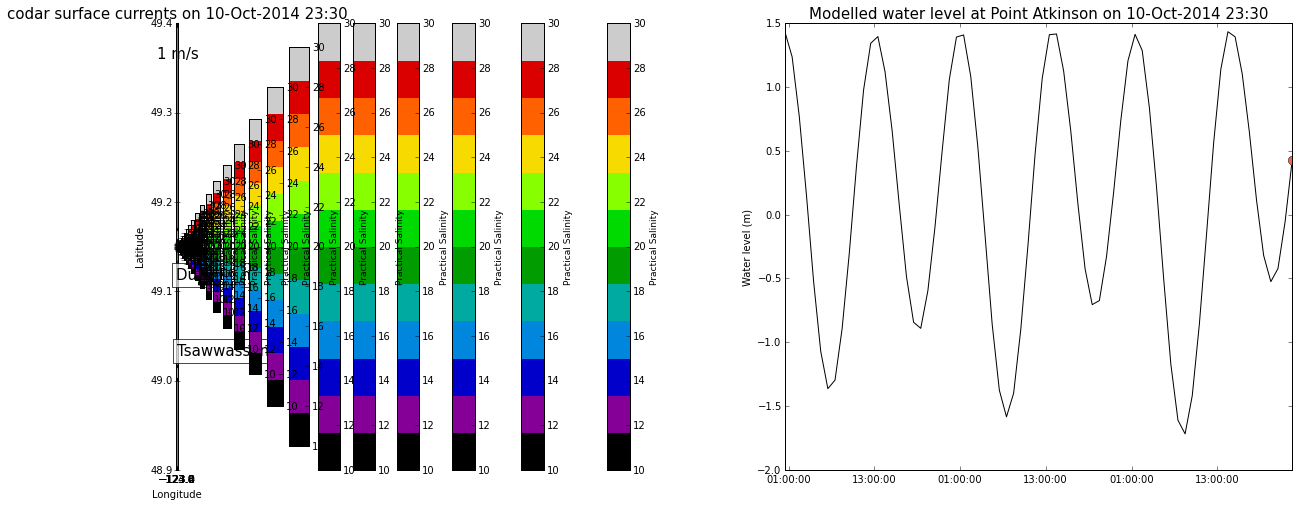

In [21]:
## make animation
#Setting up first frame and static content
run_time = datetime.datetime(2014,10,8,0)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
quiver = plot_codar(run_time)
# list all frames
framess=dateList

#The animation function    
anim = animation.FuncAnimation(fig, plot_codar, frames=dateList,  blit=True, repeat=False)

#A line that makes it all work
mywriter = animation.FFMpegWriter( fps=2, bitrate=10000)
anim.save('codar_current_salinity.mp4',writer=mywriter)